In [13]:
# import packages
import os 
import pickle

import re
from datetime import datetime

import requests

import pytz

import pandas as pd
import numpy as np

import ast


import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import *


import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


In [2]:
# import findspark
import findspark

# initialize findspark with spark directory

#ALWAYS HAVE TO BE CHANGED 
findspark.init("/Users/wouterdewitte/spark/")

# import pyspark
import pyspark
# create spark context
sc = pyspark.SparkContext()
# create spark session 
spark = pyspark.sql.SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/24 09:24:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
spark

In [3]:
#set this path to your path, for some reason I have an error 
#reading in all the files
import os 
path_json = ".././../data/Topic_vegan/*.json"

In [4]:
df_json = spark.read.json(path_json)

22/11/24 09:25:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
# select interesting features
import pyspark.sql.functions as F

df = df_json.select(F.col("user.name"),
                    F.col("user.screen_name"),
                    F.col("created_at"), 
                    F.col("full_text"),
                    F.col("user.followers_count"),
                    F.col("retweet_count"),
                    F.col("favorite_count"))
df.limit(10).toPandas()

,name,screen_name,created_at,full_text,followers_count,retweet_count,favorite_count
0,のり/Nori,nori_k_629,Mon Apr 04 10:09:55 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,139,3582,0
1,alice,myn4meizalize,Mon Apr 04 10:09:54 +0000 2022,RT @mynameisnanon: คิดถึงกันป่าว ถ้าคิดถึงต้อง...,655,3837,0
2,Karen Reed 🌸,kandk670,Mon Apr 04 10:09:54 +0000 2022,@trudiebakescake Organic coconut oil in a jar ...,711,0,0
3,ハル):),patlnwza55,Mon Apr 04 10:09:52 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,236,3582,0
4,alice,myn4meizalize,Mon Apr 04 10:09:52 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,655,3582,0
5,ﾌｧﾙﾄﾞﾗっ子organic有機💙💻,organic_yusai,Mon Apr 04 10:09:52 +0000 2022,マジでピンチ助けて自転車ガガガガ,291,0,1
6,のり/Nori,nori_k_629,Mon Apr 04 10:09:50 +0000 2022,RT @mynameisnanon: คิดถึงกันป่าว ถ้าคิดถึงต้อง...,139,3837,0
7,｡◕‿◕｡𝑱𝒆 𝒕'𝒂𝒊𝒎𝒆 🐶🧡✨,MyFnlovely97,Mon Apr 04 10:09:50 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,245,3582,0
8,Sang™,asan_gk,Mon Apr 04 10:09:50 +0000 2022,RT @NotechAna: Am I the only one who types in ...,2065,374,0
9,Trysia ):)▪︎never let me go▪︎,Winnie_thephuu,Mon Apr 04 10:09:48 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,379,3582,0


In [6]:
# remove duplicates and retweets
df = df.filter(~F.col("full_text").startswith("RT")) \
                               .drop_duplicates() \
                               .cache()

In [7]:
# https://developer.twitter.com/en/docs/twitter-ads-api/timezones
# function to convert Twitter date string format
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

# UDF declaration
date_udf = F.udf(getDate, StringType())

# apply udf
df = df.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

In [8]:
# get first post
first_post = F.min('post_created_at').alias('earliest')
# get latest post
latest_post = F.max('post_created_at').alias('latest')
# show tweet period in our dataset
df.select(first_post, latest_post).show()

+-------------------+-------------------+
|           earliest|             latest|
+-------------------+-------------------+
|2021-10-12 16:08:51|2022-10-11 23:17:33|
+-------------------+-------------------+



# The evolution of tweet activity => Zie Konstantin

Look at the frequency of tweets per month.

In [8]:
freq_month = df.withColumn("year", year(df["post_created_at"]))
freq_month = freq_month.withColumn("month", month(df["post_created_at"]))

In [9]:
freq_month.show()

+--------------------+---------------+--------------------+--------------------+---------------+-------------+--------------+-------------------+----+-----+
|                name|    screen_name|          created_at|           full_text|followers_count|retweet_count|favorite_count|    post_created_at|year|month|
+--------------------+---------------+--------------------+--------------------+---------------+-------------+--------------+-------------------+----+-----+
|        Alice Walker|   Alice7Walker|Mon Oct 18 09:30:...|@Straight_Trippy ...|            206|            0|             0|2021-10-18 09:30:22|2021|   10|
|        Jid Bullicer| pinoymarketers|Sun Oct 17 09:29:...|Organic Traffic S...|            541|            0|             0|2021-10-17 09:29:11|2021|   10|
|            Aurelius|CryptoAurelius2|Mon Oct 18 10:45:...|@IAMLLUCIANA orga...|            195|            0|             0|2021-10-18 10:45:18|2021|   10|
|  Subhash chand jain|Subhash52820845|Mon Oct 18 10:30:...

In [10]:
freq_month = freq_month.groupBy('year', 'month').agg(countDistinct("full_text"))\
                    .withColumnRenamed("count(full_text)", "freq") \
                        .sort('year', 'month', ascending = True)
freq_month = freq_month.select(concat_ws('_',freq_month.year, freq_month.month)\
                            .alias('date'), 'freq').toPandas()

22/11/24 09:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:27:45 WARN RowBasedKeyValueBatch: Calling spill() on

In [11]:
freq_month

,date,freq
0,2021_10,69557
1,2021_11,118975
2,2021_12,100368
3,2022_1,81231
4,2022_2,149690
5,2022_3,128417
6,2022_4,137894
7,2022_5,91520
8,2022_6,130127
9,2022_7,167861


In [15]:
fig = px.bar(freq_month, x='date', y='freq')

# Add figure title
fig.update_layout(
    title_text="Tweet Activity Monthly",
    title_x = 0.5
)

# add axes
fig.update_xaxes(title_text="<b>Month</b>")
fig.update_yaxes(title_text="<b>Amount of tweets</b>")

fig.show()

Look at the frequency of tweets per week.

In [27]:
freq_week = df.withColumn("year", year(df["post_created_at"]))
freq_week = freq_week.withColumn('week', weekofyear('post_created_at'))

In [28]:
freq_week.show()

+--------------------+---------------+--------------------+--------------------+---------------+-------------+--------------+-------------------+----+----+
|                name|    screen_name|          created_at|           full_text|followers_count|retweet_count|favorite_count|    post_created_at|year|week|
+--------------------+---------------+--------------------+--------------------+---------------+-------------+--------------+-------------------+----+----+
|        Alice Walker|   Alice7Walker|Mon Oct 18 09:30:...|@Straight_Trippy ...|            206|            0|             0|2021-10-18 09:30:22|2021|  42|
|        Jid Bullicer| pinoymarketers|Sun Oct 17 09:29:...|Organic Traffic S...|            541|            0|             0|2021-10-17 09:29:11|2021|  41|
|            Aurelius|CryptoAurelius2|Mon Oct 18 10:45:...|@IAMLLUCIANA orga...|            195|            0|             0|2021-10-18 10:45:18|2021|  42|
|  Subhash chand jain|Subhash52820845|Mon Oct 18 10:30:...|Organ

In [29]:
freq_week = freq_week.groupBy('year', 'week').agg(countDistinct("full_text"))\
                    .withColumnRenamed("count(full_text)", "freq") \
                        .sort('year', 'week', ascending = True)
freq_week = freq_week.select(concat_ws('_',freq_week.year, freq_week.week)\
                            .alias('date'), 'freq').toPandas()

22/11/24 09:53:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:53:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:53:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:53:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:53:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:53:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:53:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:53:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/24 09:53:21 WARN RowBasedKeyValueBatch: Calling spill() on

In [32]:
fig = px.line(freq_week, x='date', y='freq')

# Add figure title
fig.update_layout(
    title_text="Tweet Activity Weekly",
    title_x = 0.5
)

# add axes
fig.update_xaxes(title_text="<b>Week</b>")
fig.update_yaxes(title_text="<b>Amount of tweets</b>")

fig.show()

# The evolution of tweet engagement 

In [43]:
eng_weekly = df.withColumn('week', weekofyear('post_created_at'))

In [44]:
eng_weekly = eng_weekly.groupBy("week") \
                        .agg(sum("retweet_count").alias("retweets"), sum("favorite_count").alias("favorites")) \
                        .sort("week", ascending = True)

In [22]:
eng_weekly.show()

22/11/22 13:24:24 WARN MemoryStore: Not enough space to cache rdd_21_49 in memory! (computed 3.9 MiB so far)
22/11/22 13:24:24 WARN MemoryStore: Not enough space to cache rdd_21_51 in memory! (computed 3.9 MiB so far)
22/11/22 13:24:25 WARN MemoryStore: Not enough space to cache rdd_21_54 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:26 WARN MemoryStore: Not enough space to cache rdd_21_59 in memory! (computed 3.9 MiB so far)
22/11/22 13:24:26 WARN MemoryStore: Not enough space to cache rdd_21_62 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:28 WARN MemoryStore: Not enough space to cache rdd_21_67 in memory! (computed 3.9 MiB so far)
22/11/22 13:24:28 WARN MemoryStore: Not enough space to cache rdd_21_68 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:29 WARN MemoryStore: Not enough space to cache rdd_21_75 in memory! (computed 3.9 MiB so far)
22/11/22 13:24:29 WARN MemoryStore: Not enough space to cache rdd_21_78 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:33 WARN MemoryStore: Not enough space to cache rdd_21_90 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:33 WARN MemoryStore: Not enough space to cache rdd_21_94 in memory! (computed 3.9 MiB so far)
22/11/22 13:24:34 WARN MemoryStore: Not enough space to cache rdd_21_98 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:35 WARN MemoryStore: Not enough space to cache rdd_21_102 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:36 WARN MemoryStore: Not enough space to cache rdd_21_108 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:38 WARN MemoryStore: Not enough space to cache rdd_21_114 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:40 WARN MemoryStore: Not enough space to cache rdd_21_125 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:43 WARN MemoryStore: Not enough space to cache rdd_21_140 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:43 WARN MemoryStore: Not enough space to cache rdd_21_143 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:44 WARN MemoryStore: Not enough space to cache rdd_21_148 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:46 WARN MemoryStore: Not enough space to cache rdd_21_159 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_166 in memory.
22/11/22 13:24:48 WARN MemoryStore: Not enough space to cache rdd_21_166 in memory! (computed 384.0 B so far)
22/11/22 13:24:48 WARN MemoryStore: Not enough space to cache rdd_21_167 in memory! (computed 3.9 MiB so far)
22/11/22 13:24:49 WARN MemoryStore: Not enough space to cache rdd_21_169 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:49 WARN MemoryStore: Not enough space to cache rdd_21_170 in memory! (computed 3.9 MiB so far)
22/11/22 13:24:50 WARN MemoryStore: Not enough space to cache rdd_21_173 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:50 WARN MemoryStore: Not enough space to cache rdd_21_175 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:51 WARN MemoryStore: Not enough space to cache rdd_21_181 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:53 WARN MemoryStore: Not enough space to cache rdd_21_188 in memory! (computed 3.9 MiB so far)
22/11/22 13:24:53 WARN MemoryStore: Not enough space to cache rdd_21_191 in memory! (computed 3.9 MiB so far)
22/11/22 13:24:54 WARN MemoryStore: Not enough space to cache rdd_21_193 in memory! (computed 3.9 MiB so far)


22/11/22 13:24:54 WARN MemoryStore: Not enough space to cache rdd_21_195 in memory! (computed 3.9 MiB so far)
22/11/22 13:24:54 WARN MemoryStore: Not enough space to cache rdd_21_198 in memory! (computed 3.9 MiB so far)


+----+--------+---------+
|week|retweets|favorites|
+----+--------+---------+
|   1|   17154|    68580|
|   2|   21052|    76150|
|   3|   30124|   115362|
|   4|   23269|   100733|
|   5|   95331|   345437|
|   6|   56310|   282264|
|   7|   22693|   164017|
|   8|   35528|   148943|
|   9|   65765|   371656|
|  10|  104705|   617336|
|  11|    9724|    35381|
|  12|   15381|    50146|
|  13|   33285|   138162|
|  14|   54243|   195431|
|  15|   26791|   113541|
|  16|   20269|   133321|
|  17|   68675|   474810|
|  18|   15386|    61562|
|  19|   24278|    94041|
|  20|   36449|   179521|
+----+--------+---------+
only showing top 20 rows



In [45]:
eng_weekly = eng_weekly.toPandas()

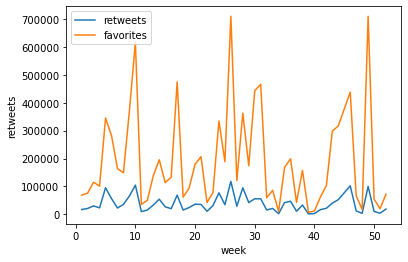

In [24]:
sns.lineplot(x = "week", y = "retweets", data = eng_weekly)
sns.lineplot(x = "week", y = "favorites", data = eng_weekly)
plt.legend(["retweets", "favorites"],loc="upper left")
plt.show()

In [65]:
fig = px.line(eng_weekly, x='week', y=eng_weekly.columns[1:3])

# Add figure title
fig.update_layout(
    title_text="Retweets vs favorites",
    title_x = 0.5
)

# add axes
fig.update_xaxes(title_text="<b>Week</b>")
fig.update_yaxes(title_text="<b>Amount</b>")

fig.show()

# The level of social media activity vs level of engagement

Engagement on Twitter is measured by the number of retweets, follows, replies, favorites, and other people’s reactions to your tweets, including the clicks on the links and hashtags in those tweets. Your Twitter engagement rate is your engagement figure divided by the number of impressions on the tweet.

According to our 2022 Social Media Industry Benchmark Report, the overall median engagement rate on Twitter is 0.037%. This is the rate for brands across all industries, from fashion to nonprofits. On average, these brands are also posting about 5 times per week.

https://www.rivaliq.com/blog/good-engagement-rate-twitter/

In [8]:
eng_rate = df.withColumn('eng_rate', ((df['favorite_count'] + df['retweet_count'])/df['followers_count']))

In [9]:
eng_rate.limit(5).toPandas()

,name,screen_name,created_at,full_text,followers_count,retweet_count,favorite_count,post_created_at,eng_rate
0,Alice Walker,Alice7Walker,Mon Oct 18 09:30:22 +0000 2021,@Straight_Trippy He have successfully delivere...,206,0,0,2021-10-18 09:30:22,0.000000
1,Jid Bullicer,pinoymarketers,Sun Oct 17 09:29:11 +0000 2021,Organic Traffic Software For Website Targeted ...,541,0,0,2021-10-17 09:29:11,0.000000
2,Aurelius,CryptoAurelius2,Mon Oct 18 10:45:18 +0000 2021,@IAMLLUCIANA organic GROwth,195,0,0,2021-10-18 10:45:18,0.000000
3,Subhash chand jain,Subhash52820845,Mon Oct 18 10:30:41 +0000 2021,"Organic Neem Leaf Powder , Azadirachta Indica ...",169,0,0,2021-10-18 10:30:41,0.000000
4,Scented Aromatics,ScentdAromatics,Tue Sep 13 21:00:01 +0000 2022,SITE WIDE 10% OFF NOW! Available on https://t....,14,4,5,2022-09-13 21:00:01,0.642857


In [10]:
eng_rate = eng_rate.withColumn('week', weekofyear('post_created_at'))

In [11]:
eng_rate_weekly = eng_rate.groupBy("week") \
                        .agg(avg("eng_rate").alias("eng_rate")) \
                        .sort("week", ascending = True)

In [12]:
eng_rate_weekly = eng_rate_weekly.toPandas()

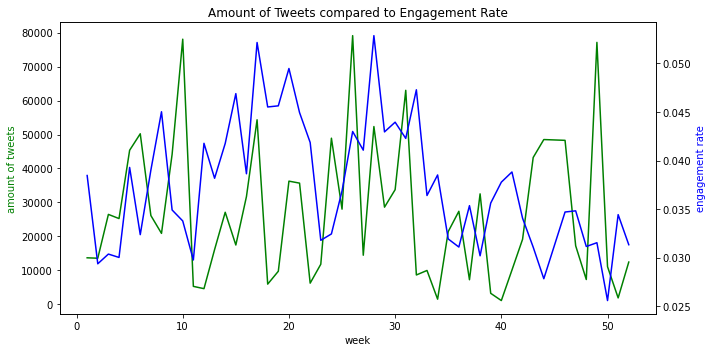

In [30]:
# plotting figures by creating axes object
# using subplots() function
fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Amount of Tweets compared to Engagement Rate')
 
# using the twinx() for creating another
# axes object for secondary y-Axis
ax2 = ax.twinx()
ax.plot("week","freq", data = freq_week, color = 'g')
ax2.plot("week", "eng_rate", data = eng_rate_weekly, color = 'b')
 
# giving labels to the axises
ax.set_xlabel('week')
ax.set_ylabel('amount of tweets', color = 'g')
 
# secondary y-axis label
ax2.set_ylabel('engagement rate', color = 'b')
 
# defining display layout
plt.tight_layout()
 
# show plot
plt.show()

In [66]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x = freq_week["week"],y = freq_week["freq"], name="Amount of tweets"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = eng_rate_weekly["week"], y = eng_rate_weekly["eng_rate"], name="Engagement rate"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Amount of tweets compared to engagement rate",
    title_x = 0.5
)


# Set x-axis title
fig.update_xaxes(title_text="week")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Amount</b> of tweets", secondary_y=False)
fig.update_yaxes(title_text="<b>Engagement</b> rate", secondary_y=True)

fig.show()

In [38]:
fig.write_html("test.html")

# The volume of influencer activity vs level of engagement 

In [12]:
df.createOrReplaceTempView('df')

In [13]:
influencers = spark.sql("SELECT LOWER(screen_name) AS screen_name, MAX(followers_count) \
                                FROM DF  \
                                WHERE followers_count IS NOT NULL \
                                GROUP BY LOWER(screen_name) \
                                ORDER BY MAX(followers_count) DESC")

In [19]:
influencers.screen_name.isin(news_sources)

Py4JJavaError: An error occurred while calling z:org.apache.spark.sql.functions.lit.
: org.apache.spark.SparkRuntimeException: The feature is not supported: literal for '{0=mashable, 1=cnnbrk, 2=big_picture, 3=theonion, 4=time, 5=breakingnews, 6=bbcbreaking, 7=espn, 8=harvardbiz, 9=gizmodo, 10=techcrunch, 11=wired, 12=wsj, 13=smashingmag, 14=pitchforkmedia, 15=rollingstone, 16=whitehouse, 17=cnn, 18=tweetmeme, 19=peoplemag, 20=natgeosociety, 21=nytimes, 22=lifehacker, 23=foxnews, 24=waitwait, 25=newsweek, 26=huffingtonpost, 27=newscientist, 28=mental_floss, 29=theeconomist, 30=emarketer, 31=engadget, 32=cracked, 33=slate, 34=bbcclick, 35=fastcompany, 36=reuters, 37=incmagazine, 38=eonline, 39=rww, 40=gdgt, 41=instyle, 42=mckquarterly, 43=enews, 44=nprnews, 45=usatoday, 46=mtv, 47=freakonomics, 48=boingboing, 49=billboarddotcom, 50=empiremagazine, 51=todayshow, 52=good, 53=gawker, 54=msnbc_breaking, 55=cbsnews, 56=guardiantech, 57=usweekly, 58=life, 59=sciam, 60=pastemagazine, 61=drudge_report, 62=parisreview, 63=latimes, 64=telegraphnews, 65=abc7, 66=arstechnica, 67=cnnmoney, 68=nprpolitics, 69=nytimesphoto, 70=nybooks, 71=nielsenwire, 72=io9, 73=sciencechannel, 74=usabreakingnews, 75=vanityfairmag, 76=cw_network, 77=bbcworld, 78=abc, 79=themoment, 80=socialmedia2day, 81=slashdot, 82=washingtonpost, 83=tpmmedia, 84=msnbc, 85=wnycradiolab, 86=cnnlive, 87=davos, 88=planetmoney, 89=cnetnews, 90=politico, 91=tvnewser, 92=guardiannews, 93=yahoonews, 94=seedmag, 95=tvguide, 96=travlandleisure, 97=newyorkpost, 98=discovermag, 99=sciencenewsorg}' of class java.util.HashMap.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.literalTypeUnsupportedError(QueryExecutionErrors.scala:296)
	at org.apache.spark.sql.catalyst.expressions.Literal$.apply(literals.scala:101)
	at org.apache.spark.sql.functions$.lit(functions.scala:125)
	at org.apache.spark.sql.functions.lit(functions.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)


In [ ]:
influencer = influencers.toPandas()

In [14]:
news_sources = pd.read_excel(".././../data/news_sources.xlsx")
news_sources = news_sources["@name"]

In [15]:
news_sources = news_sources.apply(lambda x: x[1:])

In [109]:
news_sources

0            mashable
1              cnnbrk
2         big_picture
3            theonion
4                time
           ...       
95            tvguide
96    travlandleisure
97        newyorkpost
98        discovermag
99     sciencenewsorg
Name: @name, Length: 100, dtype: object

In [126]:
influencers = influencers[~influencers["screen_name"].isin(news_sources)]

In [127]:
influencers = influencers[0:10]["screen_name"]

In [128]:
influencers

0            ladygaga
6            arrahman
7          nickiminaj
11          bjp4india
12           detikcom
13        saudinews50
14             forbes
16    rashtrapatibhvn
17               ndtv
18             aajtak
Name: screen_name, dtype: object

# Dependent variable: Google Trends

In [1]:
from pytrendsasync.request import TrendReq

from pytrends import dailydata
pytrends = TrendReq(hl='en-US', tz=360, timeout=10, proxies=['https://34.203.233.13:80',])


In [2]:
kw_list = ["healthyfood", "healthylifestyle", "vegan", "keto", "ketodiet", "ketolifestyle", "veganism", "vegetarian"]

In [57]:
df = dailydata.get_daily_data("vegan", 2021, 10, 2022, 10)
df = df.drop(df.columns[[0, 1, 2, 3]],axis = 1)
df


vegan:2021-10-01 2021-10-31
vegan:2021-11-01 2021-11-30
vegan:2021-12-01 2021-12-31
vegan:2022-01-01 2022-01-31
vegan:2022-02-01 2022-02-28
vegan:2022-03-01 2022-03-31
vegan:2022-04-01 2022-04-30
vegan:2022-05-01 2022-05-31
vegan:2022-06-01 2022-06-30
vegan:2022-07-01 2022-07-31
vegan:2022-08-01 2022-08-31
vegan:2022-09-01 2022-09-30
vegan:2022-10-01 2022-10-31


,vegan
date,
2021-10-01,NaN
2021-10-02,NaN
2021-10-03,64.08
2021-10-04,47.52
2021-10-05,51.12
...,...
2022-10-27,46.15
2022-10-28,48.75
2022-10-29,59.80


In [58]:
df.reset_index()

,date,vegan
0,2021-10-01,NaN
1,2021-10-02,NaN
2,2021-10-03,64.08
3,2021-10-04,47.52
4,2021-10-05,51.12
...,...,...
391,2022-10-27,46.15
392,2022-10-28,48.75
393,2022-10-29,59.80
394,2022-10-30,59.52


In [16]:
df["vegan_yest"] = df["vegan"].shift(1)


In [17]:
df["dependent"] = df.apply(lambda x:  1 if x["vegan"] > x["vegan_yest"] else 0, axis=1)

In [19]:
df = df.iloc[3: , :]

In [94]:
df

DataFrame[name: string, screen_name: string, created_at: string, full_text: string, followers_count: bigint, retweet_count: bigint, favorite_count: bigint, post_created_at: timestamp]

In [2]:
def get_dependent(keyword):
    # import again to avoid Google error
    from pytrendsasync.request import TrendReq
    from pytrends import dailydata

    # get the data
    df = dailydata.get_daily_data(keyword, 2021, 10, 2022, 10)

    # only get relevant keyword column
    df = df[keyword].reset_index()

    # create the binary dependent variable
    df[keyword + "_yest"] = df[keyword].shift(1)
    df["dependent_" + keyword] = df.apply(lambda x:  1 if x[keyword] > x[keyword + "_yest"] else 0, axis=1) # 1 if popularity rose compared to yesterday, otherwise 0
    
    df = df[["date", "dependent_" + keyword]]
    df = df.iloc[3: , :] # drop first 2 rows because insufficient data
    
    return df


In [4]:
df = get_dependent("healthylifestyle")

healthylifestyle:2021-10-01 2021-10-31
healthylifestyle:2021-11-01 2021-11-30
healthylifestyle:2021-12-01 2021-12-31
healthylifestyle:2022-01-01 2022-01-31
healthylifestyle:2022-02-01 2022-02-28
healthylifestyle:2022-03-01 2022-03-31
healthylifestyle:2022-04-01 2022-04-30
healthylifestyle:2022-05-01 2022-05-31
healthylifestyle:2022-06-01 2022-06-30
healthylifestyle:2022-07-01 2022-07-31
healthylifestyle:2022-08-01 2022-08-31
healthylifestyle:2022-09-01 2022-09-30
healthylifestyle:2022-10-01 2022-10-31


In [95]:
df["dependent_healthylifestyle"].value_counts()

AnalysisException: Cannot resolve column name "dependent_healthylifestyle" among (name, screen_name, created_at, full_text, followers_count, retweet_count, favorite_count, post_created_at)